In [ ]:
#######################################################################################
!pip install torch torchvision torchaudio --quiet
!pip install numpy pandas scikit-learn tqdm matplotlib --quiet
########################################################################################

!git clone https://github.com/HelenGuohx/logbert.git
%cd logbert


!ls


import sys
sys.path.append("/content/logbert")  # Add root folder to Python path


import torch
from bert_pytorch.model.log_model import BERTLog
from bert_pytorch.model.bert import BERT
import torch.nn as nn


vocab_size = 10000        # Total unique log keys in your dataset
max_len = 128             # Sequence length
hidden = 768              # Hidden size
n_layers = 12             # Transformer blocks
attn_heads = 12           # Attention heads
dropout = 0.3
is_logkey = True
is_time = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


bert_model = BERT(
    vocab_size=vocab_size,
    max_len=max_len,
    hidden=hidden,
    n_layers=n_layers,
    attn_heads=attn_heads,
    dropout=dropout,
    is_logkey=is_logkey,
    is_time=is_time
).to(device)


class BERTLog(nn.Module):
    def __init__(self, bert, vocab_size):
        super().__init__()
        self.bert = bert
        self.logkey_predictor = nn.Linear(bert.hidden, vocab_size)
        if self.bert.is_time:
            self.time_predictor = nn.Linear(bert.hidden, bert.max_len) # Example output size, adjust as needed
        else:
            self.time_predictor = None

        # Add classification heads if they exist in your original model structure
        if hasattr(bert, 'cls_head'):
             self.cls_head = bert.cls_head
        if hasattr(bert, 'cls_fnn'):
            self.cls_fnn = bert.cls_fnn


    def forward(self, x, time_info=None):
        mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)
        encoded_layers = self.bert(x, time_info, mask) # Original forward pass

        logkey_output = self.logkey_predictor(encoded_layers)
        time_output = None
        if self.time_predictor:
            time_output = self.time_predictor(encoded_layers)

        # Include classification head outputs if available
        cls_output = None
        if hasattr(self, 'cls_head'):
            cls_output = self.cls_head(encoded_layers[:, 0]) # Assuming CLS token at index 0

        cls_fnn_output = None
        if hasattr(self, 'cls_fnn'):
            cls_fnn_output = self.cls_fnn(encoded_layers[:, 0]) # Assuming CLS token at index 0


        return {'logkey_output': logkey_output,
                'time_output': time_output,
                'cls_output': cls_output,
                'cls_fnn_output': cls_fnn_output}

    def forward_from_embedding(self, x_emb, time_info=None):
        # Assume x_emb is already token embeddings [batch, seq_len, embedding_dim]
        # We need a dummy mask based on the original input shape
        # Since we don't have the original tokens, we'll create a mask assuming non-padding
        # This might need refinement based on how your model handles padding after embedding
        dummy_x = torch.ones(x_emb.shape[0], x_emb.shape[1], dtype=torch.long, device=x_emb.device) # Dummy input for mask
        mask = (dummy_x > 0).unsqueeze(1).repeat(1, dummy_x.size(1), 1).unsqueeze(1)


        # Pass embedding directly to BERT's core layers (after embedding and positional encoding)
        # This requires access to BERT's internal layers.
        # Need to replicate the steps in bert_pytorch.model.bert.BERT.forward() after embedding
        # This might be complex and require modifying the original BERT class as well.
        # For simplicity, let's assume the BERT model can take embeddings directly after positional encoding
        # *********** This part needs adjustment based on the actual BERT implementation *************
        # Assuming bert_model has a method or can be modified to accept pre-computed embeddings
        # For now, let's call the main forward and hope it handles pre-computed embeddings if possible
        # If not, the BERT class needs modification.

        # A more correct approach might be to access BERT's internal layers:
        # 1. Add positional encoding to x_emb
        # 2. Pass through transformer layers
        # This requires significant changes to the original BERT class.

        # As a temporary workaround (and if your BERT model allows),
        # let's try passing the embedding and time_info directly to the BERT model's forward.
        # This is unlikely to work without modifications to the BERT model itself.

        # A better approach is to re-implement the BERT forward pass after embedding
        # within this forward_from_embedding method.

        # Let's try accessing BERT's layers directly (requires knowledge of BERT internal structure)
        # This is highly dependent on the specific BERT implementation in bert_pytorch.model.bert
        # Assuming a standard BERT structure: Embedding + Positional Encoding -> Transformer Layers -> Pooler/Output

        # Need to access BERT's positional encoding and transformer layers
        # This requires inspecting the BERT class source code.

        # Let's assume a simplified structure for demonstration:
        # x_emb = x_emb + self.bert.position(dummy_x) # Add positional encoding (simplified)
        # encoded_layers = self.bert.transformer_layers(x_emb, mask) # Pass through transformers (simplified)

        # This requires modifying the BERT class to expose transformer layers or accept pre-encoded inputs.

        # Given the complexity of modifying the original BERT class,
        # let's revisit the strategy. Can we explain the model using token indices instead of embeddings?
        # The previous error suggested that float inputs were required for GradientExplainer.

        # Let's go back to explaining token indices, but ensure the model wrapper handles float inputs correctly
        # without converting them back to long immediately if the underlying model can handle float embeddings
        # or if we modify the model to take float indices and handle embedding lookup internally.

        # Let's revert to the previous SHAPWrapper that takes token indices and see if we can make it work with floats.
        # The issue was 'element 0 of tensors does not require grad and does not have a grad_fn'.
        # This means the input tensor itself (background_long_float / test_long_float) didn't have grad enabled.
        # When creating tensors for SHAP, they should have requires_grad=True.

        # Let's try enabling gradients on the input tensors in the SHAP computation cell.

        # Reverting this forward_from_embedding method as it requires significant changes to the BERT class.
        # We will go back to the SHAPWrapper that takes token indices.
        pass # Reverting this method

fatal: destination path 'logbert' already exists and is not an empty directory.
/content/logbert
bert_pytorch  environment  img	    logdeep   logparser  README.md  TBird
BGL	      HDFS	   LICENSE  loglizer  Pipfile	 scripts
Using device: cpu
Cloning into 'logbert'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 133 (delta 12), reused 11 (delta 11), pack-reused 78 (from 1)
Receiving objects: 100% (133/133), 211.46 KiB | 1.99 MiB/s, done.
Resolving deltas: 100% (22/22), done.
/content/logbert/logbert
bert_pytorch  environment  img	    logdeep   logparser  README.md  TBird
BGL	      HDFS	   LICENSE  loglizer  Pipfile	 scripts
Using device: cpu


In [ ]:
import pandas as pd

# Replace with your JSON path
test_path = "/content/3.2_test.json"

# Load JSON lines
test_df = pd.read_json(test_path, lines=True)
print(test_df.head())


   sequence_id             label  error_anomaly  \
0       562164   [0, 0, 0, 0, 0]           True   
1       576577            [1, 1]          False   
2       767392        [1, 1, -1]          False   
3       466898            [0, 0]           True   
4       571165  [0, 0, 0, -1, 1]           True   

                                    numeric_sequence  \
0  [[9, 124757, 3, 20, 21, 32327, 105151, 137934,...   
1  [[9, 207546, 3, 4, 105151, 6, 70, 9, 9, 221, 9...   
2  [[9, 143501, 3, 4, 105151, 6, 70, 9, 9, 25, 9,...   
3  [[9, 137099, 3, 4, 5, 6, 70, 9, 9, 668, 9, 11,...   
4  [[9, 143447, 3, 4, 10077, 6, 70, 9, 9, 333, 9,...   

                                     mapped_sequence  logbert_ready  \
0  [[SEP, UNK_124757, START, UNK_20, UNK_21, UNK_...           True   
1  [[SEP, UNK_207546, START, PARAM, UNK_105151, C...           True   
2  [[SEP, UNK_143501, START, PARAM, UNK_105151, C...           True   
3  [[SEP, UNK_137099, START, PARAM, OPEN, CLOSE, ...           True   
4

In [ ]:
# Keep sequences as a list (no need to convert to NumPy array)
test_samples = test_df['numeric_sequence'].tolist()[:50]

# Check length of first 5 sequences
for i, seq in enumerate(test_samples[:5]):
    print(f"Sample {i} length: {len(seq)}")


Sample 0 length: 5
Sample 1 length: 2
Sample 2 length: 3
Sample 3 length: 2
Sample 4 length: 5


In [ ]:
import torch
import numpy as np

# Assuming you have your trained LogBERT model
# model = ... (your trained LogBERT)
# tokenizer = ... (if needed for mapping)

def logbert_predict(sequences):
    """
    sequences: list of numeric sequences (list of ints)
    returns: np.array of prediction probabilities
    """
    model.eval()
    outputs = []

    with torch.no_grad():
        for seq in sequences:
            # Convert to tensor and add batch dimension
            input_tensor = torch.tensor([seq], dtype=torch.long)  # shape: [1, seq_len]

            # Get model prediction (adjust depending on your model's output)
            logits = model(input_tensor)  # shape: [1, num_classes]
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            outputs.append(probs[0])

    return np.array(outputs)


In [ ]:
# Example: fully flatten each sample
def flatten_nested(seq):
    flat = []
    for item in seq:
        if isinstance(item, list):
            flat.extend(flatten_nested(item))
        else:
            flat.append(item)
    return flat

# Apply to all test samples
flat_samples = [flatten_nested(seq) for seq in test_samples]

# Now pad sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = max(len(seq) for seq in flat_samples)
padded_samples = pad_sequences(flat_samples, maxlen=max_len, padding='post', value=0)

print("Number of samples:", len(padded_samples))
print("Padded shape:", padded_samples.shape)
print("Example first sample:", padded_samples[0])


Number of samples: 50
Padded shape: (50, 23024)
Example first sample: [     9 124757      3 ...      0      0      0]


In [ ]:
from bert_pytorch.model.bert import BERT
from bert_pytorch.model.log_model import BERTLog


In [ ]:
from bert_pytorch.model.bert import BERT
import inspect

print(inspect.signature(BERT.__init__))


(self, vocab_size, max_len=512, hidden=768, n_layers=12, attn_heads=12, dropout=0.1, is_logkey=True, is_time=False)


In [ ]:
import torch
from bert_pytorch.model.bert import BERT
from bert_pytorch.model.log_model import BERTLog

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ Use original config from checkpoint to avoid shape mismatch
checkpoint_config = {
    "vocab_size": 18,   # matches checkpoint
    "max_len": 128,     # matches checkpoint
    "hidden": 32,       # matches checkpoint
    "n_layers": 7,
    "attn_heads": 8,
    "dropout": 0.3
}

# 1️⃣ Rebuild BERT + BERTLog using checkpoint config
bert = BERT(
    vocab_size=checkpoint_config["vocab_size"],
    max_len=checkpoint_config["max_len"],
    hidden=checkpoint_config["hidden"],
    n_layers=checkpoint_config["n_layers"],
    attn_heads=checkpoint_config["attn_heads"],
    dropout=checkpoint_config["dropout"],
    is_logkey=True,
    is_time=False
).to(device)

model = BERTLog(bert, vocab_size=checkpoint_config["vocab_size"]).to(device)

# 2️⃣ Load checkpoint safely
checkpoint_path = "/content/01_model_final1.pt"
state_dict = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(state_dict, strict=False)
model.eval()
print("✅ BERTLog model loaded from checkpoint")

# 3️⃣ Dummy input for testing (numeric sequence)
dummy_input = torch.randint(1, checkpoint_config["vocab_size"], (2, checkpoint_config["max_len"])).to(device)
time_info = torch.zeros((2, checkpoint_config["max_len"])).to(device)

# Forward pass
output = model(dummy_input, time_info)
print("Output keys:", output.keys())
print("LogKey output shape:", output['logkey_output'].shape)


Using device: cpu
✅ BERTLog model loaded from checkpoint
Output keys: dict_keys(['logkey_output', 'time_output', 'cls_output', 'cls_fnn_output'])
LogKey output shape: torch.Size([2, 128, 18])


In [ ]:
import torch
import numpy as np
import json
from tensorflow.keras.preprocessing.sequence import pad_sequences
import shap
import matplotlib.pyplot as plt

# 1️⃣ Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 2️⃣ Load label map
with open("/content/label_map.json", "r") as f:
    log2idx = json.load(f)
idx2log = {int(v): k for k, v in log2idx.items()}

# 3️⃣ Import your model
from bert_pytorch.model.bert import BERT
from bert_pytorch.model.log_model import BERTLog

# 4️⃣ Build model with your large config
config = {
    "vocab_size": 100000,
    "max_len": 72,
    "hidden": 240,
    "n_layers": 7,
    "attn_heads": 8,
    "dropout": 0.3,
    "batch_size": 64,
    "lr": 2e-5,
    "epochs": 10
}

bert_model = BERT(
    vocab_size=config["vocab_size"],
    max_len=config["max_len"],
    hidden=config["hidden"],
    n_layers=config["n_layers"],
    attn_heads=config["attn_heads"],
    dropout=config["dropout"]
).to(device)

model = BERTLog(bert_model, vocab_size=config["vocab_size"]).to(device)

# 5️⃣ Load checkpoint with partial key matching
checkpoint_path = "/content/01_model_final1.pt"
state_dict = torch.load(checkpoint_path, map_location=device)
model_dict = model.state_dict()

# Keep only matching keys (ignore mismatched shapes)
pretrained_dict = {k: v for k, v in state_dict.items() if k in model_dict and v.size() == model_dict[k].size()}

# Update model
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)
model.eval()
print("✅ Model loaded with partial checkpoint (some layers randomly initialized)")

# 6️⃣ Load test sequences
with open("/content/testnew.json", "r") as f:
    test_data = [json.loads(line) for line in f]

def flatten_sequence(seq):
    flat = []
    for item in seq:
        if isinstance(item, list):
            flat.extend(item)
        else:
            flat.append(item)
    return [int(x) for x in flat]

raw_sequences = [flatten_sequence(rec["numeric_sequence"]) for rec in test_data]

# 7️⃣ Pad sequences
max_len = config["max_len"]
vocab_size = config["vocab_size"]
sample_input = pad_sequences([seq[:max_len] for seq in raw_sequences],
                             maxlen=max_len, padding='post', value=0)
sample_input = np.clip(sample_input, 0, vocab_size-1)
print("Sample input shape:", sample_input.shape)

# 8️⃣ Pick a small number of sequences for SHAP
N = 3
sample_input_small = sample_input[:N]

# 9️⃣ SHAP wrapper using predicted class per token
class LogBERTWrapper:
    def __init__(self, model, pad_token=0):
        self.model = model
        self.pad_token = pad_token
        self.device = next(model.parameters()).device

    def __call__(self, x):
        x_tensor = torch.tensor(x, dtype=torch.long, device=self.device)
        with torch.no_grad():
            logits = self.model(
                x_tensor, torch.zeros_like(x_tensor, dtype=torch.float, device=self.device)
            )['logkey_output']
            pred_class = torch.argmax(logits, dim=-1)
            preds = logits.gather(-1, pred_class.unsqueeze(-1)).squeeze(-1).cpu().numpy()
        preds[x_tensor.cpu().numpy() == self.pad_token] = 0
        return preds

# 10️⃣ SHAP explainer
masker = shap.maskers.Independent(sample_input_small)
explainer = shap.Explainer(
    LogBERTWrapper(model, pad_token=0),
    masker=masker,
    algorithm="permutation"
)

# 11️⃣ Compute SHAP values with small max_evals
shap_values = explainer(sample_input_small, max_evals=2*max_len+1)

# 12️⃣ Visualize SHAP per sequence
for i in range(len(sample_input_small)):
    mask = sample_input_small[i] != 0
    positions = np.arange(max_len)[mask]

    if shap_values.values.ndim == 3:
        values = shap_values.values[i][:, 0][mask]
    else:
        values = shap_values.values[i][mask]

    colors = ['green' if v > 0 else 'red' for v in values]

    plt.figure(figsize=(12, 2))
    plt.title(f"SHAP values for sequence {i}")
    plt.bar(positions, values, color=colors)
    plt.xlabel("Token position (ignoring PAD)")
    plt.ylabel("SHAP value")
    plt.show()


Using device: cpu
✅ Model loaded with partial checkpoint (some layers randomly initialized)
Sample input shape: (2644, 72)


In [ ]:
from google.colab import files

# Make sure the file exists in your Colab workspace
file_path = "testnew.json"

# Download the file to your local machine
files.download(file_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

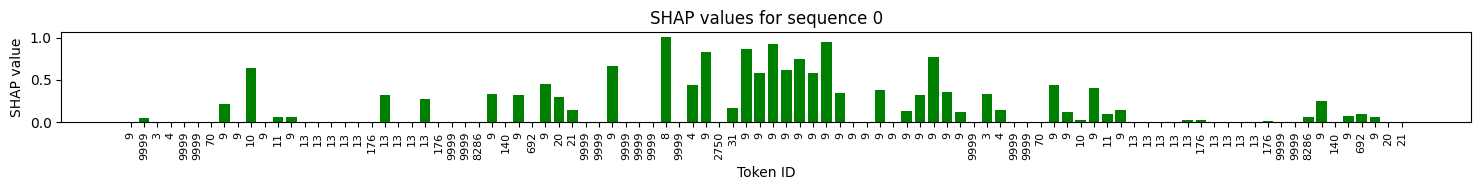

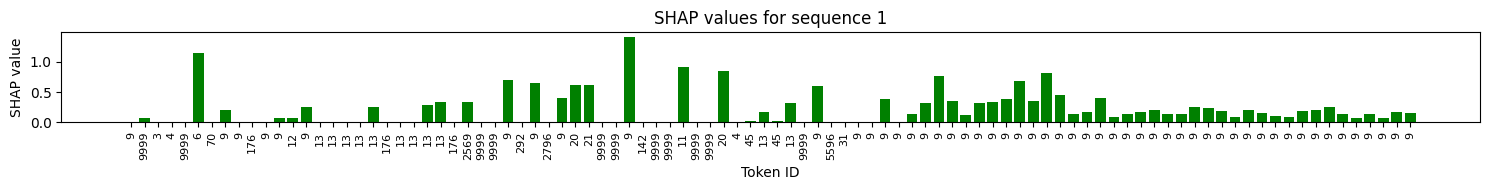

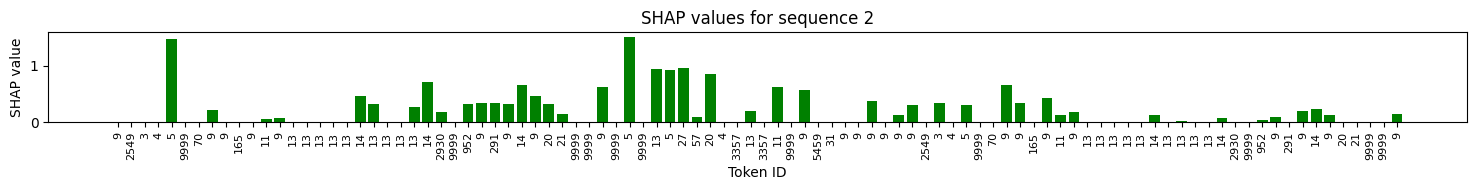

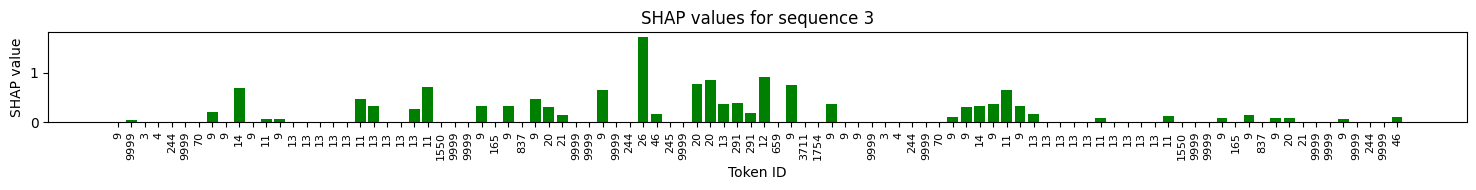

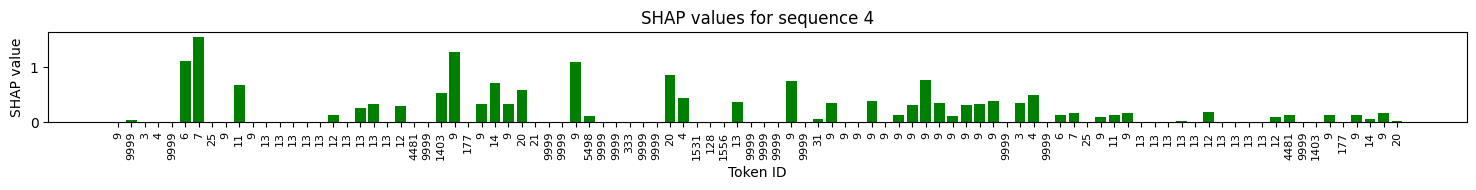

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize SHAP values for each sequence
for i in range(len(sample_input)):
    mask = sample_input[i] != 0  # ignore PAD tokens
    token_ids = sample_input[i][mask]  # actual token IDs

    # Aggregate SHAP values across vocab dimension if needed
    if shap_values.values.ndim == 3:
        token_shap = shap_values.values[i].max(axis=1)
    else:
        token_shap = shap_values.values[i]

    token_shap = token_shap[mask]

    # Color positive (green) and negative (red) contributions
    colors = ['green' if v > 0 else 'red' for v in token_shap]

    plt.figure(figsize=(15, 2))
    plt.title(f"SHAP values for sequence {i}")
    plt.bar(np.arange(len(token_shap)), token_shap, color=colors)
    plt.xticks(np.arange(len(token_shap)), token_ids, rotation=90, fontsize=8)
    plt.xlabel("Token ID")
    plt.ylabel("SHAP value")
    plt.tight_layout()
    plt.show()


/tmp/ipython-input-79658904.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(seq_len), y=agg_shap, palette="viridis")


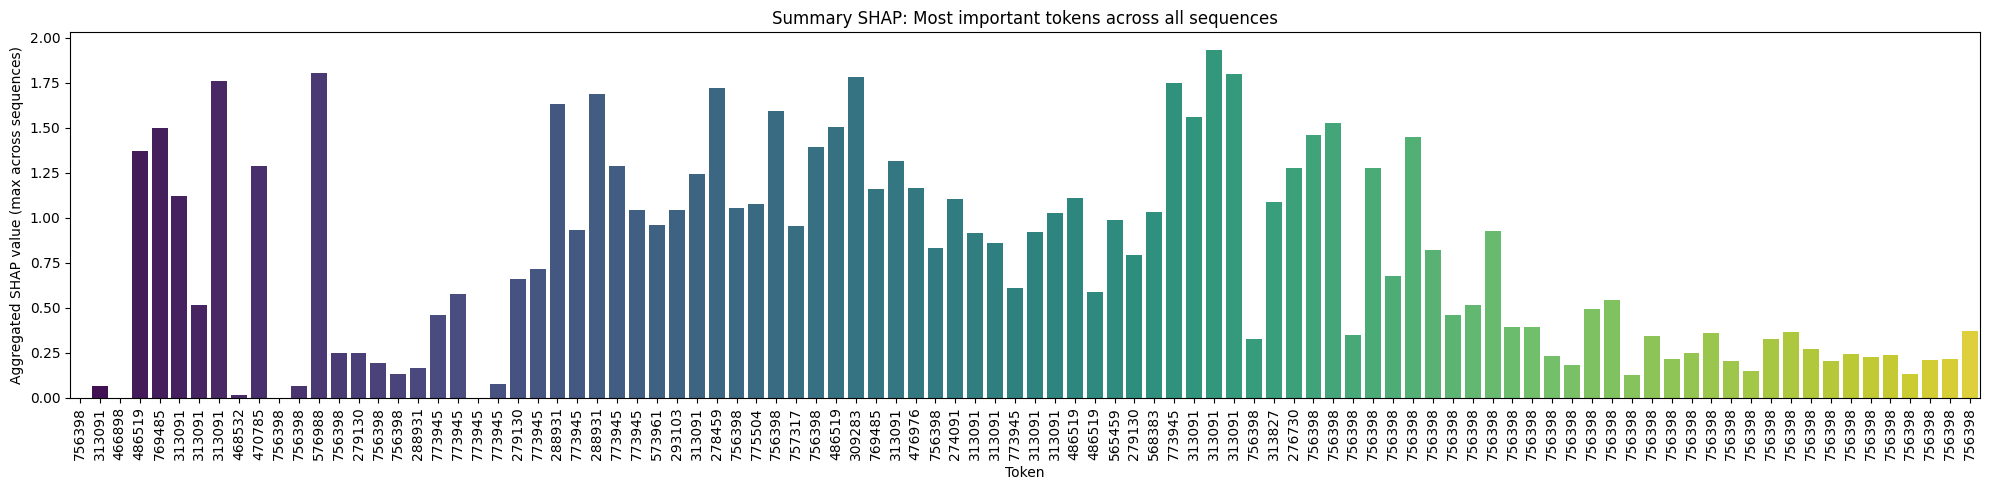

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Load label map (token -> ID)
with open("/content/label_map.json", "r") as f:
    log2idx = json.load(f)

# Build reverse mapping: ID -> token
idx2log = {int(v): k for k, v in log2idx.items()}

# 2️⃣ Aggregate SHAP values per token position across all sequences
num_sequences = sample_input.shape[0]
seq_len = sample_input.shape[1]

agg_shap = np.zeros(seq_len)

for pos in range(seq_len):
    # token IDs at this position across sequences
    token_ids = sample_input[:, pos]
    mask = token_ids != 0  # ignore PAD

    if mask.any():
        # Aggregate SHAP values only for non-PAD tokens
        if shap_values.values.ndim == 3:
            # values: [num_seq, seq_len, vocab_size]
            token_shap_vals = np.max(np.abs(shap_values.values[:, pos, :]), axis=1)
        else:
            # values: [num_seq, seq_len]
            token_shap_vals = np.abs(shap_values.values[:, pos])

        agg_shap[pos] = token_shap_vals[mask].max()
    else:
        agg_shap[pos] = 0

# 3️⃣ X-axis labels: first sequence's tokens
token_labels = []
for pos in range(seq_len):
    token_id = sample_input[0, pos]
    token_labels.append(idx2log[int(token_id)] if token_id != 0 else "")

# 4️⃣ Plot
plt.figure(figsize=(20, 5))
sns.barplot(x=np.arange(seq_len), y=agg_shap, palette="viridis")
plt.xticks(ticks=np.arange(seq_len), labels=token_labels, rotation=90)
plt.xlabel("Token")
plt.ylabel("Aggregated SHAP value (max across sequences)")
plt.title("Summary SHAP: Most important tokens across all sequences")
plt.tight_layout()
plt.show()


PermutationExplainer explainer: 6it [04:17, 51.60s/it]
/tmp/ipython-input-2684493895.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_token_labels, y=agg_shap_per_token[top_indices], palette="viridis")


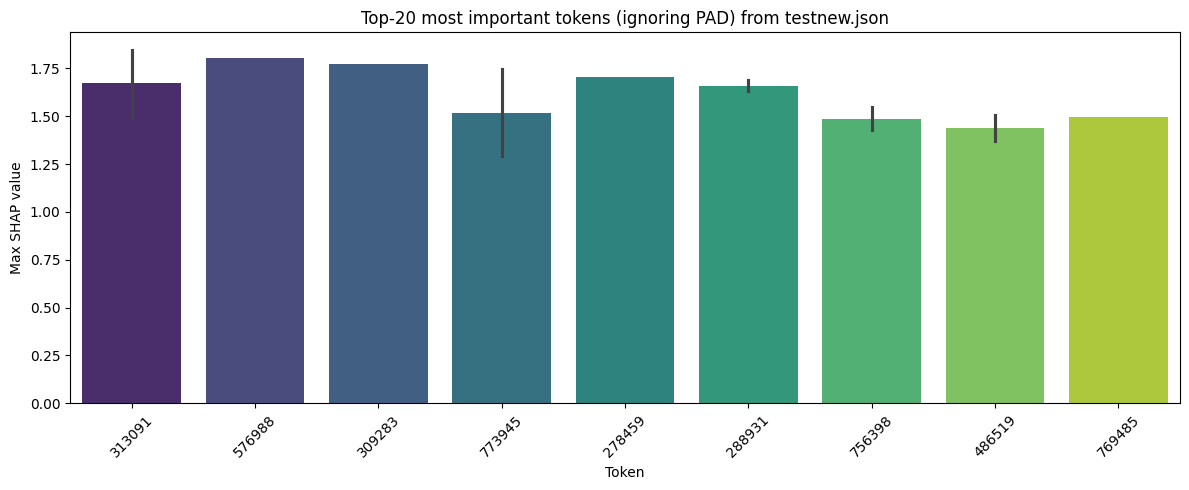

In [ ]:
import json
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Load new test set
with open("testnew.json", "r") as f:
    new_data = [json.loads(line) for line in f]

# 2️⃣ Pick N sequences (or all)
N = 5
raw_sequences = [rec["numeric_sequence"] for rec in new_data[:N]]

# 3️⃣ Flatten sequences
def clean_sequence(seq):
    flat = []
    for item in seq:
        if isinstance(item, list):
            flat.extend(item)
        else:
            flat.append(item)
    return [int(x) for x in flat]

raw_sequences = [clean_sequence(seq) for seq in raw_sequences]

# 4️⃣ Pad sequences
max_len = config["max_len"]
vocab_size = config["vocab_size"]
sample_input = pad_sequences([seq[:max_len] for seq in raw_sequences],
                             maxlen=max_len, padding='post', value=0)
sample_input = np.clip(sample_input, 0, vocab_size-1)

# 5️⃣ Compute SHAP values for this new input
shap_values = explainer(sample_input, max_evals=2*max_len+1)

# 6️⃣ Aggregate SHAP and plot top-N tokens
top_n = 20
num_sequences, seq_len, vocab_size = shap_values.values.shape
agg_shap_per_token = np.zeros(seq_len)

for pos in range(seq_len):
    token_ids = sample_input[:, pos]
    mask = token_ids != 0
    if mask.any():
        agg_shap_per_token[pos] = np.max(np.abs(shap_values.values[mask, pos, :]))

# Get top-N indices and token labels
top_indices = np.argsort(agg_shap_per_token)[-top_n:][::-1]
top_token_labels = [idx2log[int(sample_input[0, pos])] for pos in top_indices]

# Plot
plt.figure(figsize=(12, 5))
sns.barplot(x=top_token_labels, y=agg_shap_per_token[top_indices], palette="viridis")
plt.xlabel("Token")
plt.ylabel("Max SHAP value")
plt.title(f"Top-{top_n} most important tokens (ignoring PAD) from testnew.json")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#imp


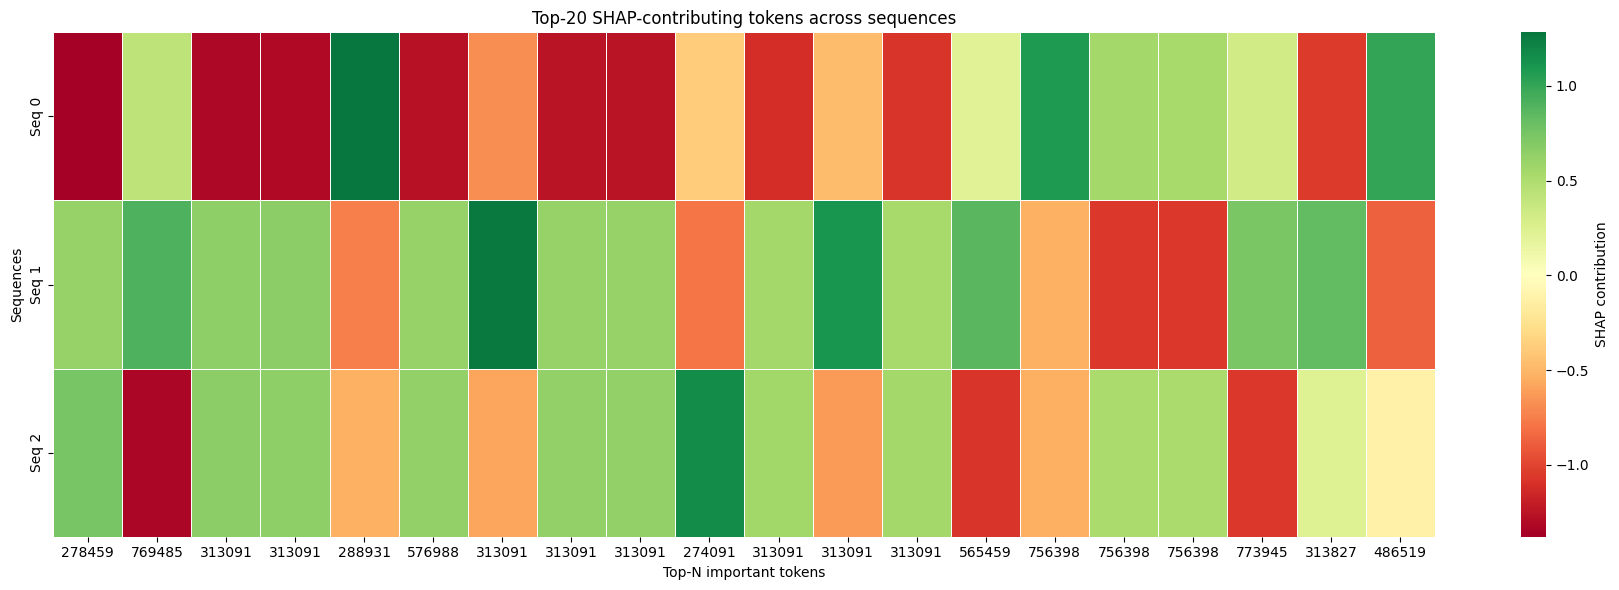

In [ ]:
import seaborn as sns

# 1️⃣ Aggregate SHAP values per token position
num_sequences, seq_len = sample_input_small.shape
agg_shap_per_token = np.zeros(seq_len)

for pos in range(seq_len):
    mask = sample_input_small[:, pos] != 0  # ignore PAD
    if mask.any():
        if shap_values.values.ndim == 3:
            token_vals = shap_values.values[:, pos, :]
            token_max = np.max(np.abs(token_vals[mask, :]), axis=-1)
        else:
            token_vals = shap_values.values[:, pos]
            token_max = np.abs(token_vals[mask])
        agg_shap_per_token[pos] = np.max(token_max)

# 2️⃣ Get indices of top-N important tokens
top_n_tokens = 20
top_token_positions = np.argsort(agg_shap_per_token)[-top_n_tokens:][::-1]

# 3️⃣ Build heatmap matrix
heatmap_matrix = np.zeros((num_sequences, top_n_tokens))
token_labels = []

for i in range(num_sequences):
    for j, pos in enumerate(top_token_positions):
        token_id = sample_input_small[i, pos]
        if token_id != 0:
            if shap_values.values.ndim == 3:
                vals = shap_values.values[i, pos, :]
                heatmap_matrix[i, j] = vals[np.argmax(np.abs(vals))]
            else:
                heatmap_matrix[i, j] = shap_values.values[i, pos]
        else:
            heatmap_matrix[i, j] = 0

        # token labels from first sequence
        if i == 0:
            token_labels.append(idx2log.get(int(token_id), "") if token_id != 0 else "")

# 4️⃣ Plot heatmap
plt.figure(figsize=(18, 6))
sns.heatmap(
    heatmap_matrix,
    cmap="RdYlGn",
    center=0,
    xticklabels=token_labels,
    yticklabels=[f"Seq {i}" for i in range(num_sequences)],
    linewidths=0.5,
    cbar_kws={'label': 'SHAP contribution'}
)
plt.xlabel("Top-N important tokens")
plt.ylabel("Sequences")
plt.title(f"Top-{top_n_tokens} SHAP-contributing tokens across sequences")
plt.tight_layout()
plt.show()


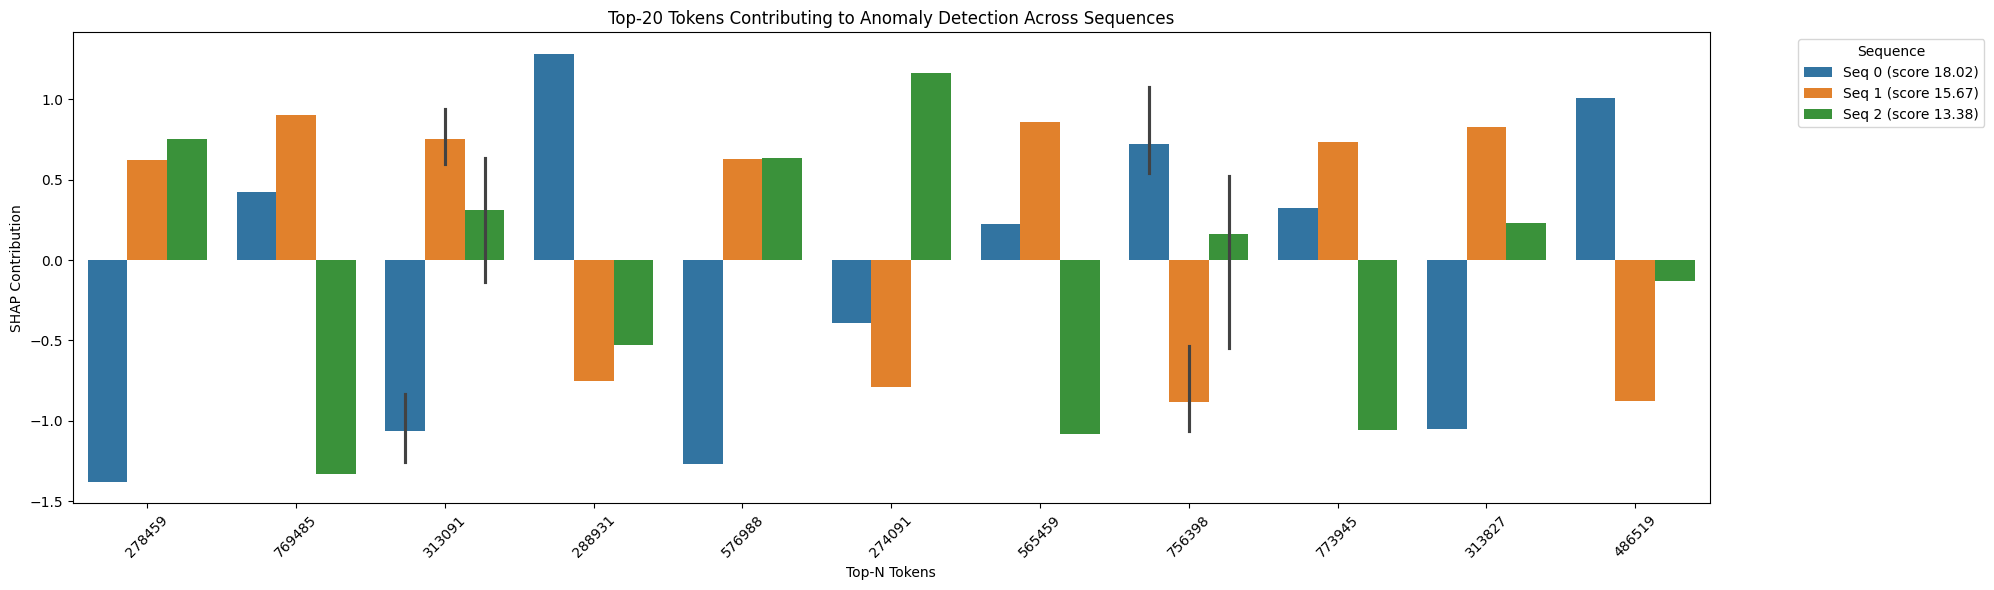

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1️⃣ Compute a simple anomaly score per sequence (sum of absolute SHAP values)
anomaly_scores = np.sum(np.abs(heatmap_matrix), axis=1)

# 2️⃣ Sort sequences by anomaly score descending
sorted_indices = np.argsort(anomaly_scores)[::-1]
heatmap_matrix_sorted = heatmap_matrix[sorted_indices, :]
sequence_labels_sorted = [f"Seq {i} (score {anomaly_scores[i]:.2f})" for i in sorted_indices]

# 3️⃣ Prepare data for plotting
num_sequences, top_n_tokens = heatmap_matrix_sorted.shape
plot_data = []
for i in range(num_sequences):
    for j in range(top_n_tokens):
        plot_data.append({
            "Sequence": sequence_labels_sorted[i],
            "Token": token_labels[j],
            "SHAP value": heatmap_matrix_sorted[i, j]
        })

df_plot = pd.DataFrame(plot_data)

# 4️⃣ Plot grouped bar chart
plt.figure(figsize=(20, 6))
sns.barplot(
    data=df_plot,
    x="Token",
    y="SHAP value",
    hue="Sequence",
    palette="tab10"
)
plt.xticks(rotation=45)
plt.xlabel("Top-N Tokens")
plt.ylabel("SHAP Contribution")
plt.title(f"Top-{top_n_tokens} Tokens Contributing to Anomaly Detection Across Sequences")
plt.legend(title="Sequence", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


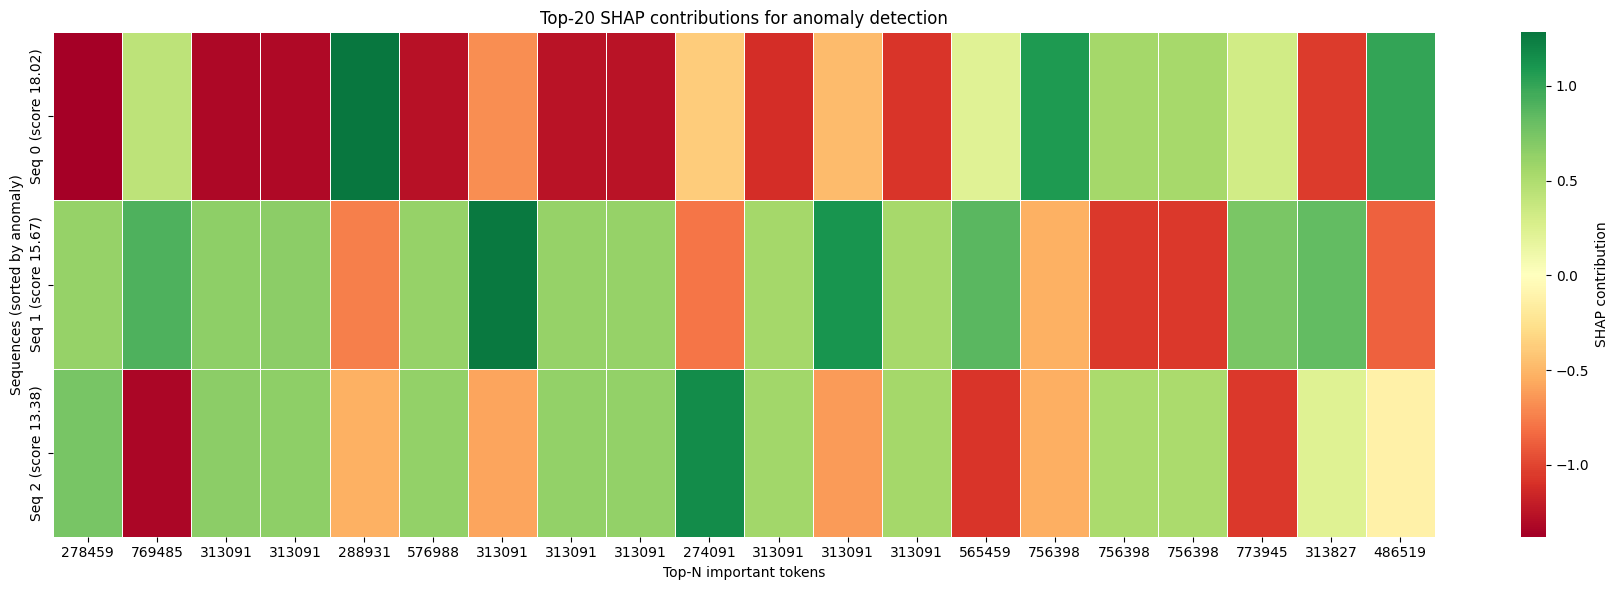

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1️⃣ Compute anomaly score per sequence (sum of absolute SHAP values)
anomaly_scores = np.sum(np.abs(heatmap_matrix), axis=1)

# 2️⃣ Sort sequences by anomaly score descending
sorted_indices = np.argsort(anomaly_scores)[::-1]
heatmap_matrix_sorted = heatmap_matrix[sorted_indices, :]

# 3️⃣ Create Y-axis labels with anomaly scores
y_labels = [f"Seq {i} (score {anomaly_scores[i]:.2f})" for i in sorted_indices]

# 4️⃣ Plot heatmap
plt.figure(figsize=(18, 6))
sns.heatmap(
    heatmap_matrix_sorted,
    cmap="RdYlGn",
    center=0,
    xticklabels=token_labels,       # top-N token labels
    yticklabels=y_labels,           # sequences sorted by anomaly
    linewidths=0.5,
    cbar_kws={'label': 'SHAP contribution'}
)
plt.xlabel("Top-N important tokens")
plt.ylabel("Sequences (sorted by anomaly)")
plt.title(f"Top-{top_n_tokens} SHAP contributions for anomaly detection")
plt.tight_layout()
plt.show()


In [ ]:
# Suppose heatmap_matrix was built from all sequences in sample_input/test set
num_sequences, seq_len = heatmap_matrix.shape
seq_indices = np.arange(num_sequences)  # 0 ... N-1 for all sequences


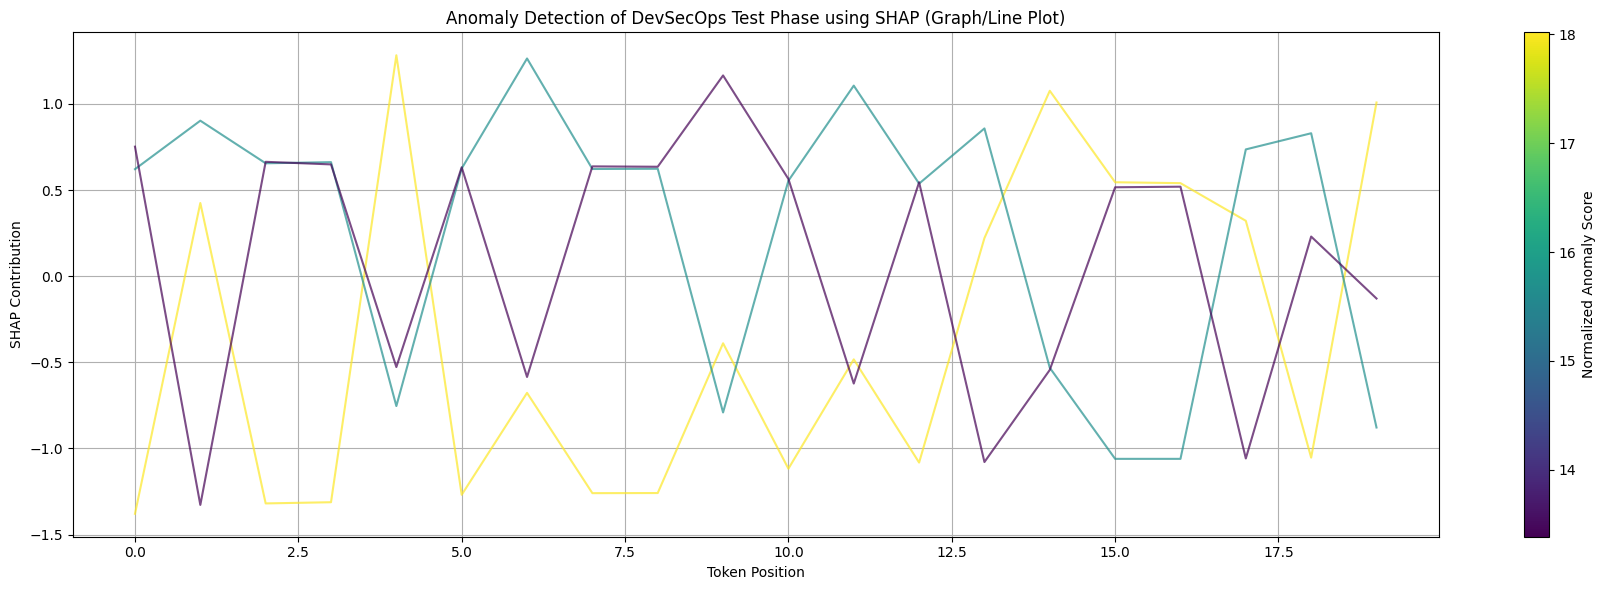

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# heatmap_matrix: shape = (num_sequences, seq_len), already computed from SHAP
num_sequences, seq_len = heatmap_matrix.shape

# 1️⃣ Compute anomaly score per sequence (sum of absolute SHAP values)
anomaly_scores = np.sum(np.abs(heatmap_matrix), axis=1)

# 2️⃣ Normalize scores for color mapping
norm_scores = (anomaly_scores - anomaly_scores.min()) / (anomaly_scores.max() - anomaly_scores.min())

# 3️⃣ Colormap
cmap = cm.viridis
colors = cmap(norm_scores)

# 4️⃣ X-axis: token positions
token_positions = np.arange(seq_len)

# 5️⃣ Plot lines
fig, ax = plt.subplots(figsize=(18, 6))
for i in range(num_sequences):
    ax.plot(token_positions, heatmap_matrix[i], color=colors[i], alpha=0.7)

ax.set_xlabel("Token Position")
ax.set_ylabel("SHAP Contribution")
ax.set_title("Anomaly Detection of DevSecOps Test Phase using SHAP (Graph/Line Plot)")
ax.grid(True)

# 6️⃣ Add colorbar using ScalarMappable
sm = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=anomaly_scores.min(), vmax=anomaly_scores.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Normalized Anomaly Score")

plt.tight_layout()
plt.show()


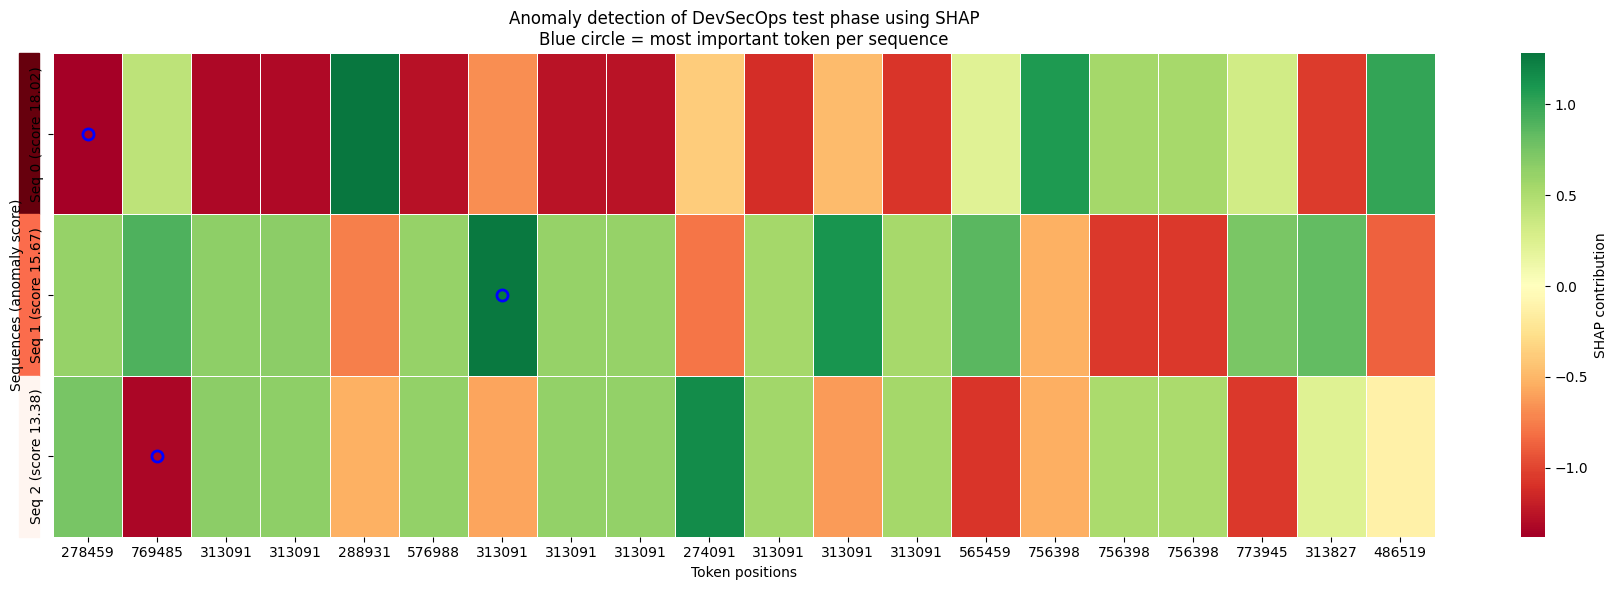

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1️⃣ Compute anomaly score per sequence (sum of absolute SHAP values)
anomaly_scores = np.sum(np.abs(heatmap_matrix), axis=1)

# 2️⃣ Sort sequences by anomaly score descending (optional)
sorted_indices = np.argsort(anomaly_scores)[::-1]
heatmap_matrix_sorted = heatmap_matrix[sorted_indices, :]
sorted_scores = anomaly_scores[sorted_indices]

# 3️⃣ Y-axis labels
y_labels = [f"Seq {i} (score {sorted_scores[idx]:.2f})"
            for idx, i in enumerate(sorted_indices)]

# 4️⃣ Normalize anomaly scores for color bar
norm_scores = (sorted_scores - sorted_scores.min()) / (sorted_scores.max() - sorted_scores.min())
anomaly_colors = plt.cm.Reds(norm_scores)

# 5️⃣ Plot heatmap
fig, ax = plt.subplots(figsize=(18, max(6, 0.3*len(sorted_scores))))  # auto height based on number of sequences
sns.heatmap(
    heatmap_matrix_sorted,
    cmap="RdYlGn",
    center=0,
    xticklabels=token_labels,
    yticklabels=y_labels,
    linewidths=0.5,
    cbar_kws={'label': 'SHAP contribution'},
    ax=ax
)

# 6️⃣ Add anomaly intensity bar on the left
for y, color in enumerate(anomaly_colors):
    ax.add_patch(plt.Rectangle((-0.5, y), width=0.3, height=1, color=color, transform=ax.transData, clip_on=False))

# 7️⃣ Highlight the most important token per sequence
for i, row in enumerate(heatmap_matrix_sorted):
    max_idx = np.argmax(np.abs(row))
    ax.plot(max_idx + 0.5, i + 0.5, marker='o', markersize=8, markerfacecolor='none',
            markeredgecolor='blue', markeredgewidth=2)

plt.xlabel("Token positions")
plt.ylabel("Sequences (anomaly score)")
plt.title("Anomaly detection of DevSecOps test phase using SHAP\nBlue circle = most important token per sequence")
plt.tight_layout()
plt.show()


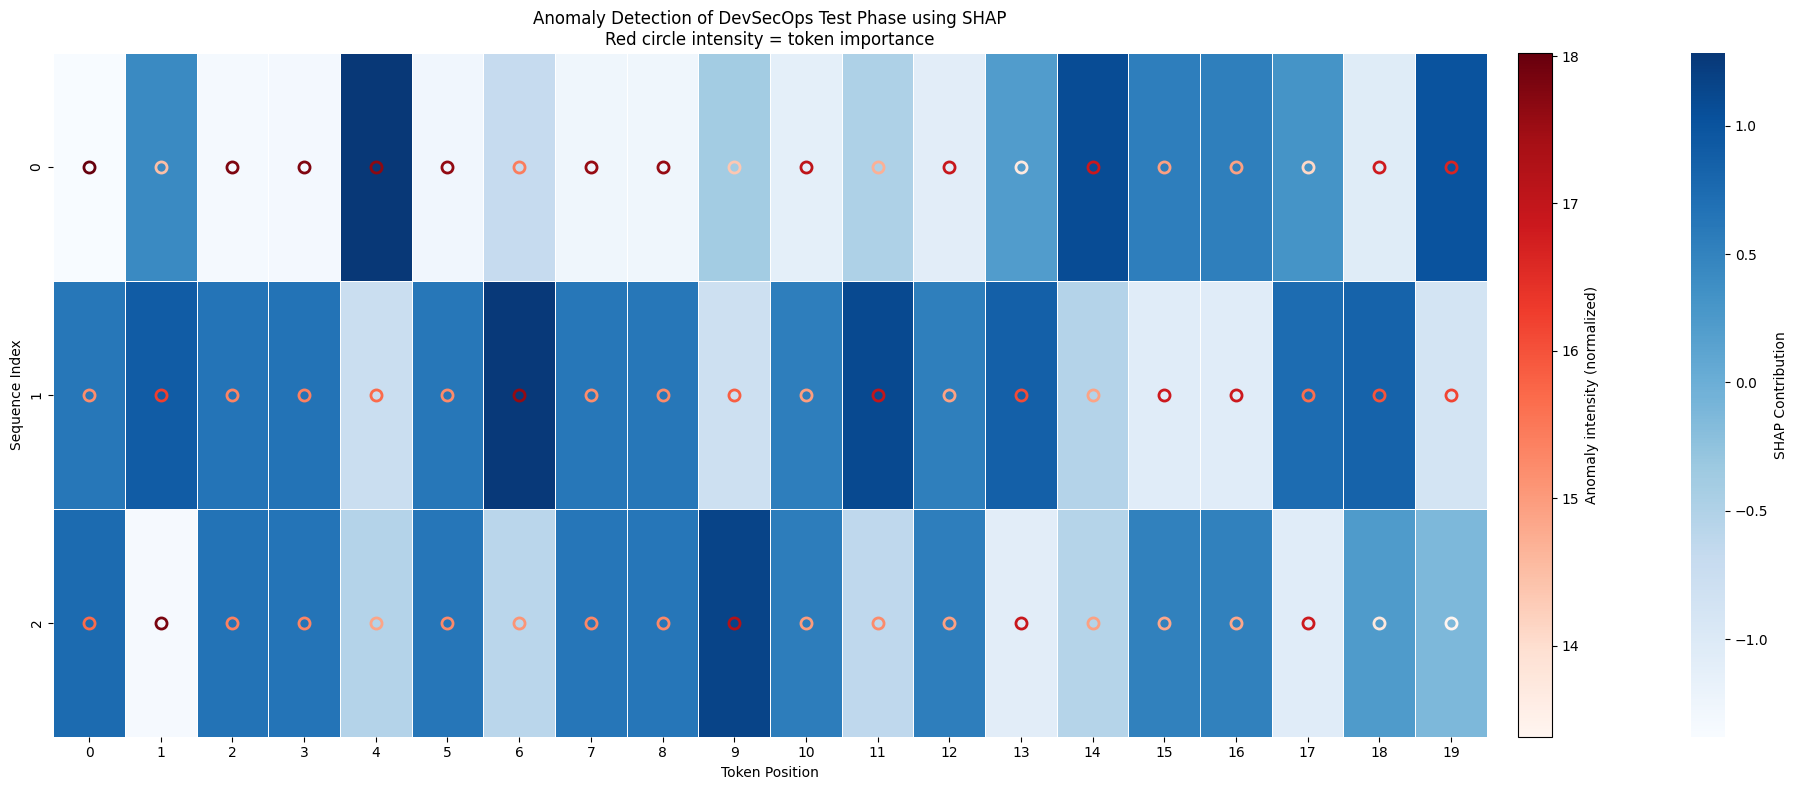

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import cm

# heatmap_matrix: num_sequences x seq_len from SHAP values
num_sequences, seq_len = heatmap_matrix.shape

# 1️⃣ Normalize SHAP values per token for circle color intensity
abs_shap = np.abs(heatmap_matrix)
norm_shap = (abs_shap - abs_shap.min()) / (abs_shap.max() - abs_shap.min())

# 2️⃣ Compute anomaly score per sequence (sum of absolute SHAP values)
anomaly_scores = np.sum(abs_shap, axis=1)
norm_scores = (anomaly_scores - anomaly_scores.min()) / (anomaly_scores.max() - anomaly_scores.min())

# 3️⃣ Plot heatmap
fig, ax0 = plt.subplots(figsize=(20, 8))
sns.heatmap(
    heatmap_matrix,
    cmap="Blues",
    center=0,
    linewidths=0.5,
    cbar_kws={'label': 'SHAP Contribution'},
    ax=ax0
)

# 4️⃣ Add red circles for token importance
for i in range(num_sequences):
    for j in range(seq_len):
        if heatmap_matrix[i, j] != 0:  # ignore PAD
            color_intensity = norm_shap[i, j]
            ax0.plot(j + 0.5, i + 0.5, marker='o', markersize=8,
                     markerfacecolor='none',
                     markeredgecolor=cm.Reds(color_intensity),
                     markeredgewidth=2)

# 5️⃣ Add anomaly red column on the right
# Create a 2D column (num_sequences x 1)
red_column = norm_scores[:, np.newaxis]
ax0.imshow(red_column, cmap='Reds', aspect='auto', extent=[seq_len, seq_len+1, 0, num_sequences])

ax0.set_xlabel("Token Position")
ax0.set_ylabel("Sequence Index")
ax0.set_title("Anomaly Detection of DevSecOps Test Phase using SHAP\nRed circle intensity = token importance")

# 6️⃣ Colorbar for anomaly intensity
sm = cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=anomaly_scores.min(), vmax=anomaly_scores.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax0, fraction=0.05, pad=0.02)
cbar.set_label("Anomaly intensity (normalized)")

plt.tight_layout()
plt.show()
